In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from data_extract_clean import stem_tokenizer
from analysis_functions import display_topics, find_unique, get_main_topics, get_sentiment
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('vader_lexicon')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stephan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/stephan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Topic Modeling by Chapter

The main goal for this project was to experiment with topic modeling on a chapter by chapter basis.

In [2]:
chapters = pd.read_pickle('../data_files/chapter_corpus.pickle')

In [3]:
stop_words = stopwords.words('english')
stop_words.extend(['becaus', 'said'])
porter_stemmer = PorterStemmer()
stop_words_stemmed = [porter_stemmer.stem(word) for word in stop_words]

In [4]:
tf1 = TfidfVectorizer(stop_words=stop_words_stemmed, ngram_range=(1, 1), tokenizer=stem_tokenizer, min_df=2, max_df=0.9)
chapters_tf1 = tf1.fit_transform(chapters)
chapters_dtm = pd.DataFrame(chapters_tf1.toarray(), columns=tf1.get_feature_names())

In [5]:
nmf = NMF(15)
nmf_model = nmf.fit(chapters_dtm)
doc_topic = nmf_model.transform(chapters_dtm)

# Naming topics from NMF and creating Dataframe:
topics = ['rand_main', 'Nynaeve', 'mat', 'perrin_wolfbrother', 'egwene_amyrlin', 'loial_rand', 'siuan_moiraine',
         'aviendha_aiel', 'elayne_queen', 'moiraine_lan', 'tuon_seanchan', 'puppeteers_main', 'min_viewings', 'black_tower_last_battle',
         'gawyn']

display_topics(nmf_model, tf1.get_feature_names(), 15, topic_names=topics)


Topic: ' rand_main '
rand, therin, lew, basher, dragon, lord, tam, taim, saidin, maiden, sword, citi, aiel, weiramon, kill

Topic: ' Nynaeve '
nynaev, elayn, moghedien, thom, juilin, liandrin, luca, dream, telaranrhiod, door, channel, braid, galad, ship, tanchico

Topic: ' mat '
mat, thom, bloodi, talman, dice, olver, noal, gleeman, gholam, vanin, nalesean, cauthon, inn, mayb, tylin

Topic: ' perrin_wolfbrother '
perrin, fail, berelain, gaul, hopper, wolv, elya, masema, slayer, wolf, aram, galad, whitecloak, smell, lord

Topic: ' egwene_amyrlin '
egwen, amyrlin, sheriam, elaida, tower, verin, novic, sitter, ajah, silviana, romanda, hall, dream, sister, mother

Topic: ' loial_rand '
loial, hurin, rand, ingtar, ogier, verin, selen, horn, fain, lord, sted, waygat, trolloc, sniffer, perrin

Topic: ' siuan_moiraine '
siuan, moirain, sister, sheriam, bryne, elaida, myrel, amyrlin, lelain, tower, novic, romanda, sitter, lean, tamra

Topic: ' aviendha_aiel '
aviendha, aiel, wise, ami, rhuarc,

In [6]:
doc_topics_df = pd.DataFrame(doc_topic, columns= topics)

### Add Analysis fields

Now that the topics are defined, I can add some more features that can help with analysis down the line.

In [7]:
# Add clean text to topics for merge
doc_topics_df['clean_text'] = chapters

# Add metadata for books, chapters etc
metadata = pd.read_pickle('../data_files/extracted_text.pickle')
metadata.drop(columns='index', inplace=True)
combined = metadata.merge(doc_topics_df, how='left', on='clean_text')

# Add word count for each chapter
combined['word_count'] = combined['clean_text'].str.count(' ') + 1

In [8]:
# Calculate unique words for each chapter
combined['unique_words'] = combined.loc[:,'clean_text'].apply(find_unique)

In [9]:
# Find the main topic for each chapter
combined['main_topic'] = get_main_topics(combined, topics)

In [10]:
# Get Vader sentiment scores for each chapter
combined['sent_neg'] = combined.text.apply(get_sentiment, args=('neg',))
combined['sent_pos'] = combined.text.apply(get_sentiment, args=('pos',))
combined['sent_neu'] = combined.text.apply(get_sentiment, args=('neu',))
combined['sent_comp'] = combined.text.apply(get_sentiment, args=('compound',))

In [11]:
combined.to_pickle('../data_files/chapter_result.pickle')
combined.to_csv('../data_files/chapter_viz.csv')

### Visualizations

#### Chapters

First I wanted to see how these topics show up across all chapters. I created a heatmap where the intensity of color is the weight of that topic in the document. I manually added lines to show here a new book starts, based on the chapter numbers. Creating a threshold (vmin) made the picture much clearer, as did using the 'robust' setting.

In [13]:
df = pd.read_pickle('../data_files/chapter_result.pickle')

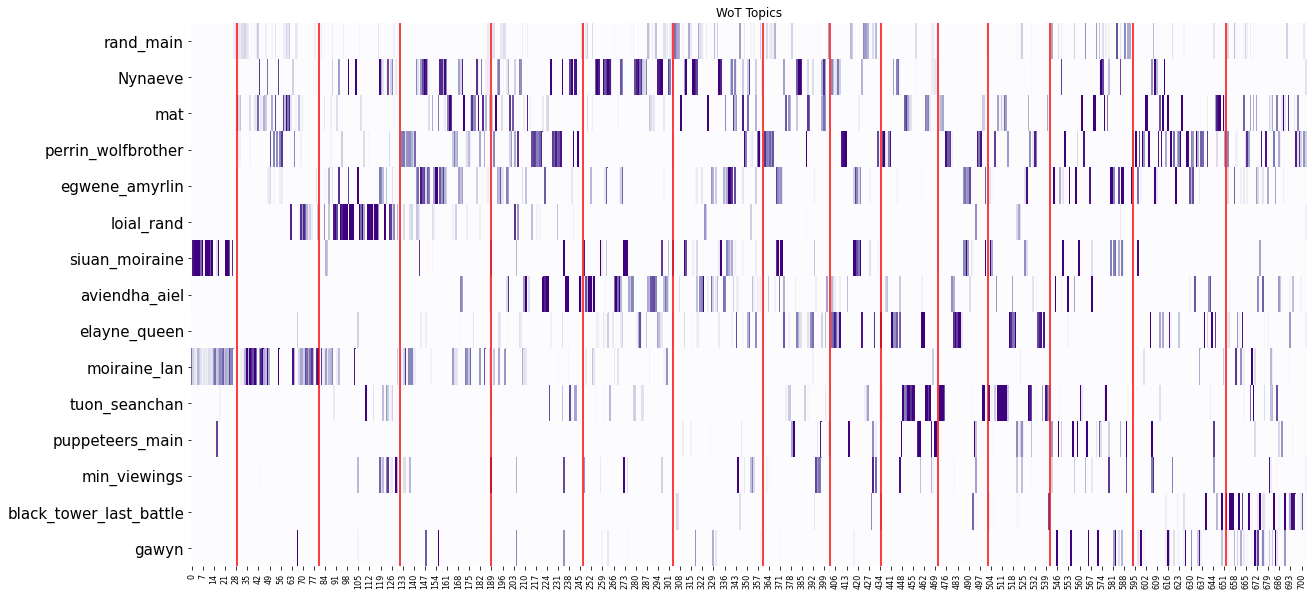

In [14]:
# Topic Viz by chapter, all books
fig, ax = plt.subplots(figsize=(20,10))
plt.title('WoT Topics')
sns.heatmap(df[topics].T, cmap='Purples', robust=True, cbar=False, vmin = 0.05)
plt.yticks(fontsize=15)
plt.xticks(fontsize=8)
plt.vlines([29,81,132,189,247,304,361,403,435,471,503,542,594,653],0,15,colors='red')
fig.savefig('../viz/Main.png', dpi=600, bbox_inches='tight', transparent=False)
plt.show;

Next I used the same technique to zoom in on a specific book. I compare this to a high level summary of the same book found online. The result can be seen in the presentation.

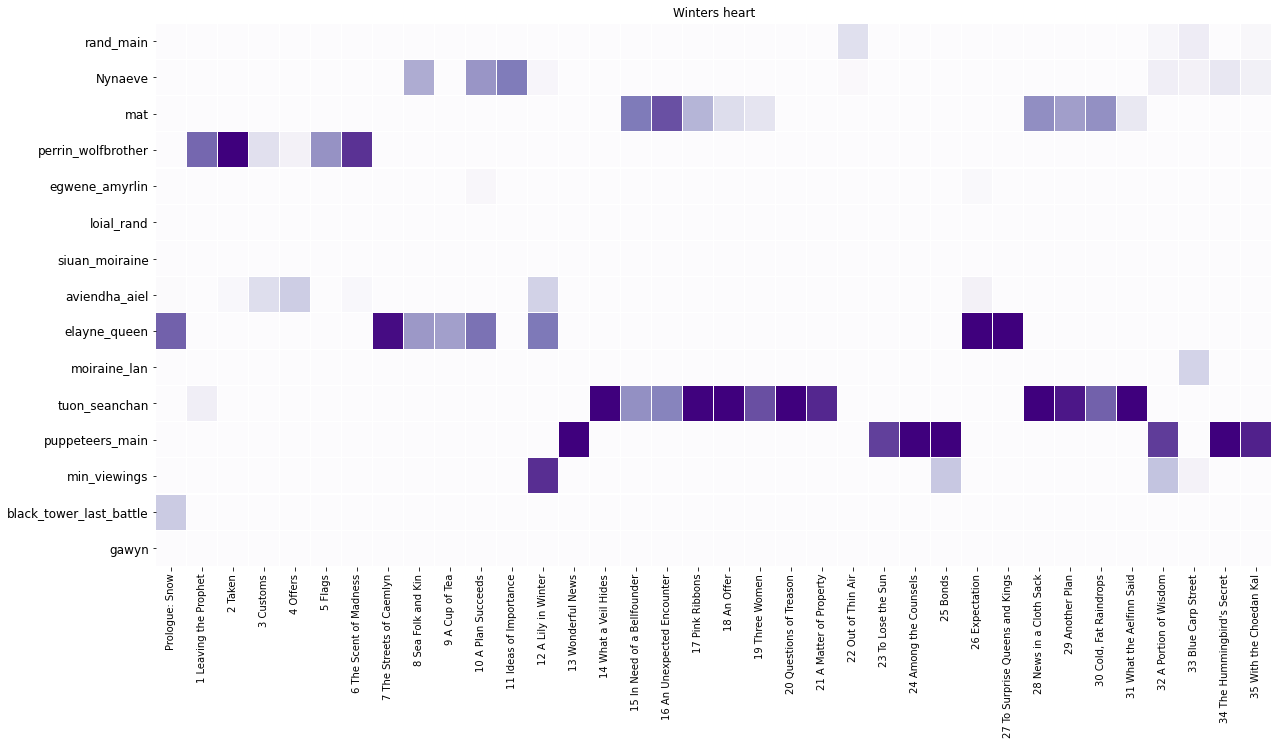

In [15]:
# Individual book
title= 'Winters heart'
selected = df[df.book_title == title]

fig, ax = plt.subplots(figsize=(20,10))
plt.title(title)
sns.heatmap(selected[topics].T, cmap='Purples', robust=True, cbar=False, xticklabels=selected.chapter_title, 
            linewidths=0.2, vmin= 0.05)
plt.yticks(fontsize=12)
plt.xticks(fontsize=10)
fig.savefig('../viz/WH.png', dpi=600, bbox_inches='tight', transparent=False)
plt.show;

#### All books

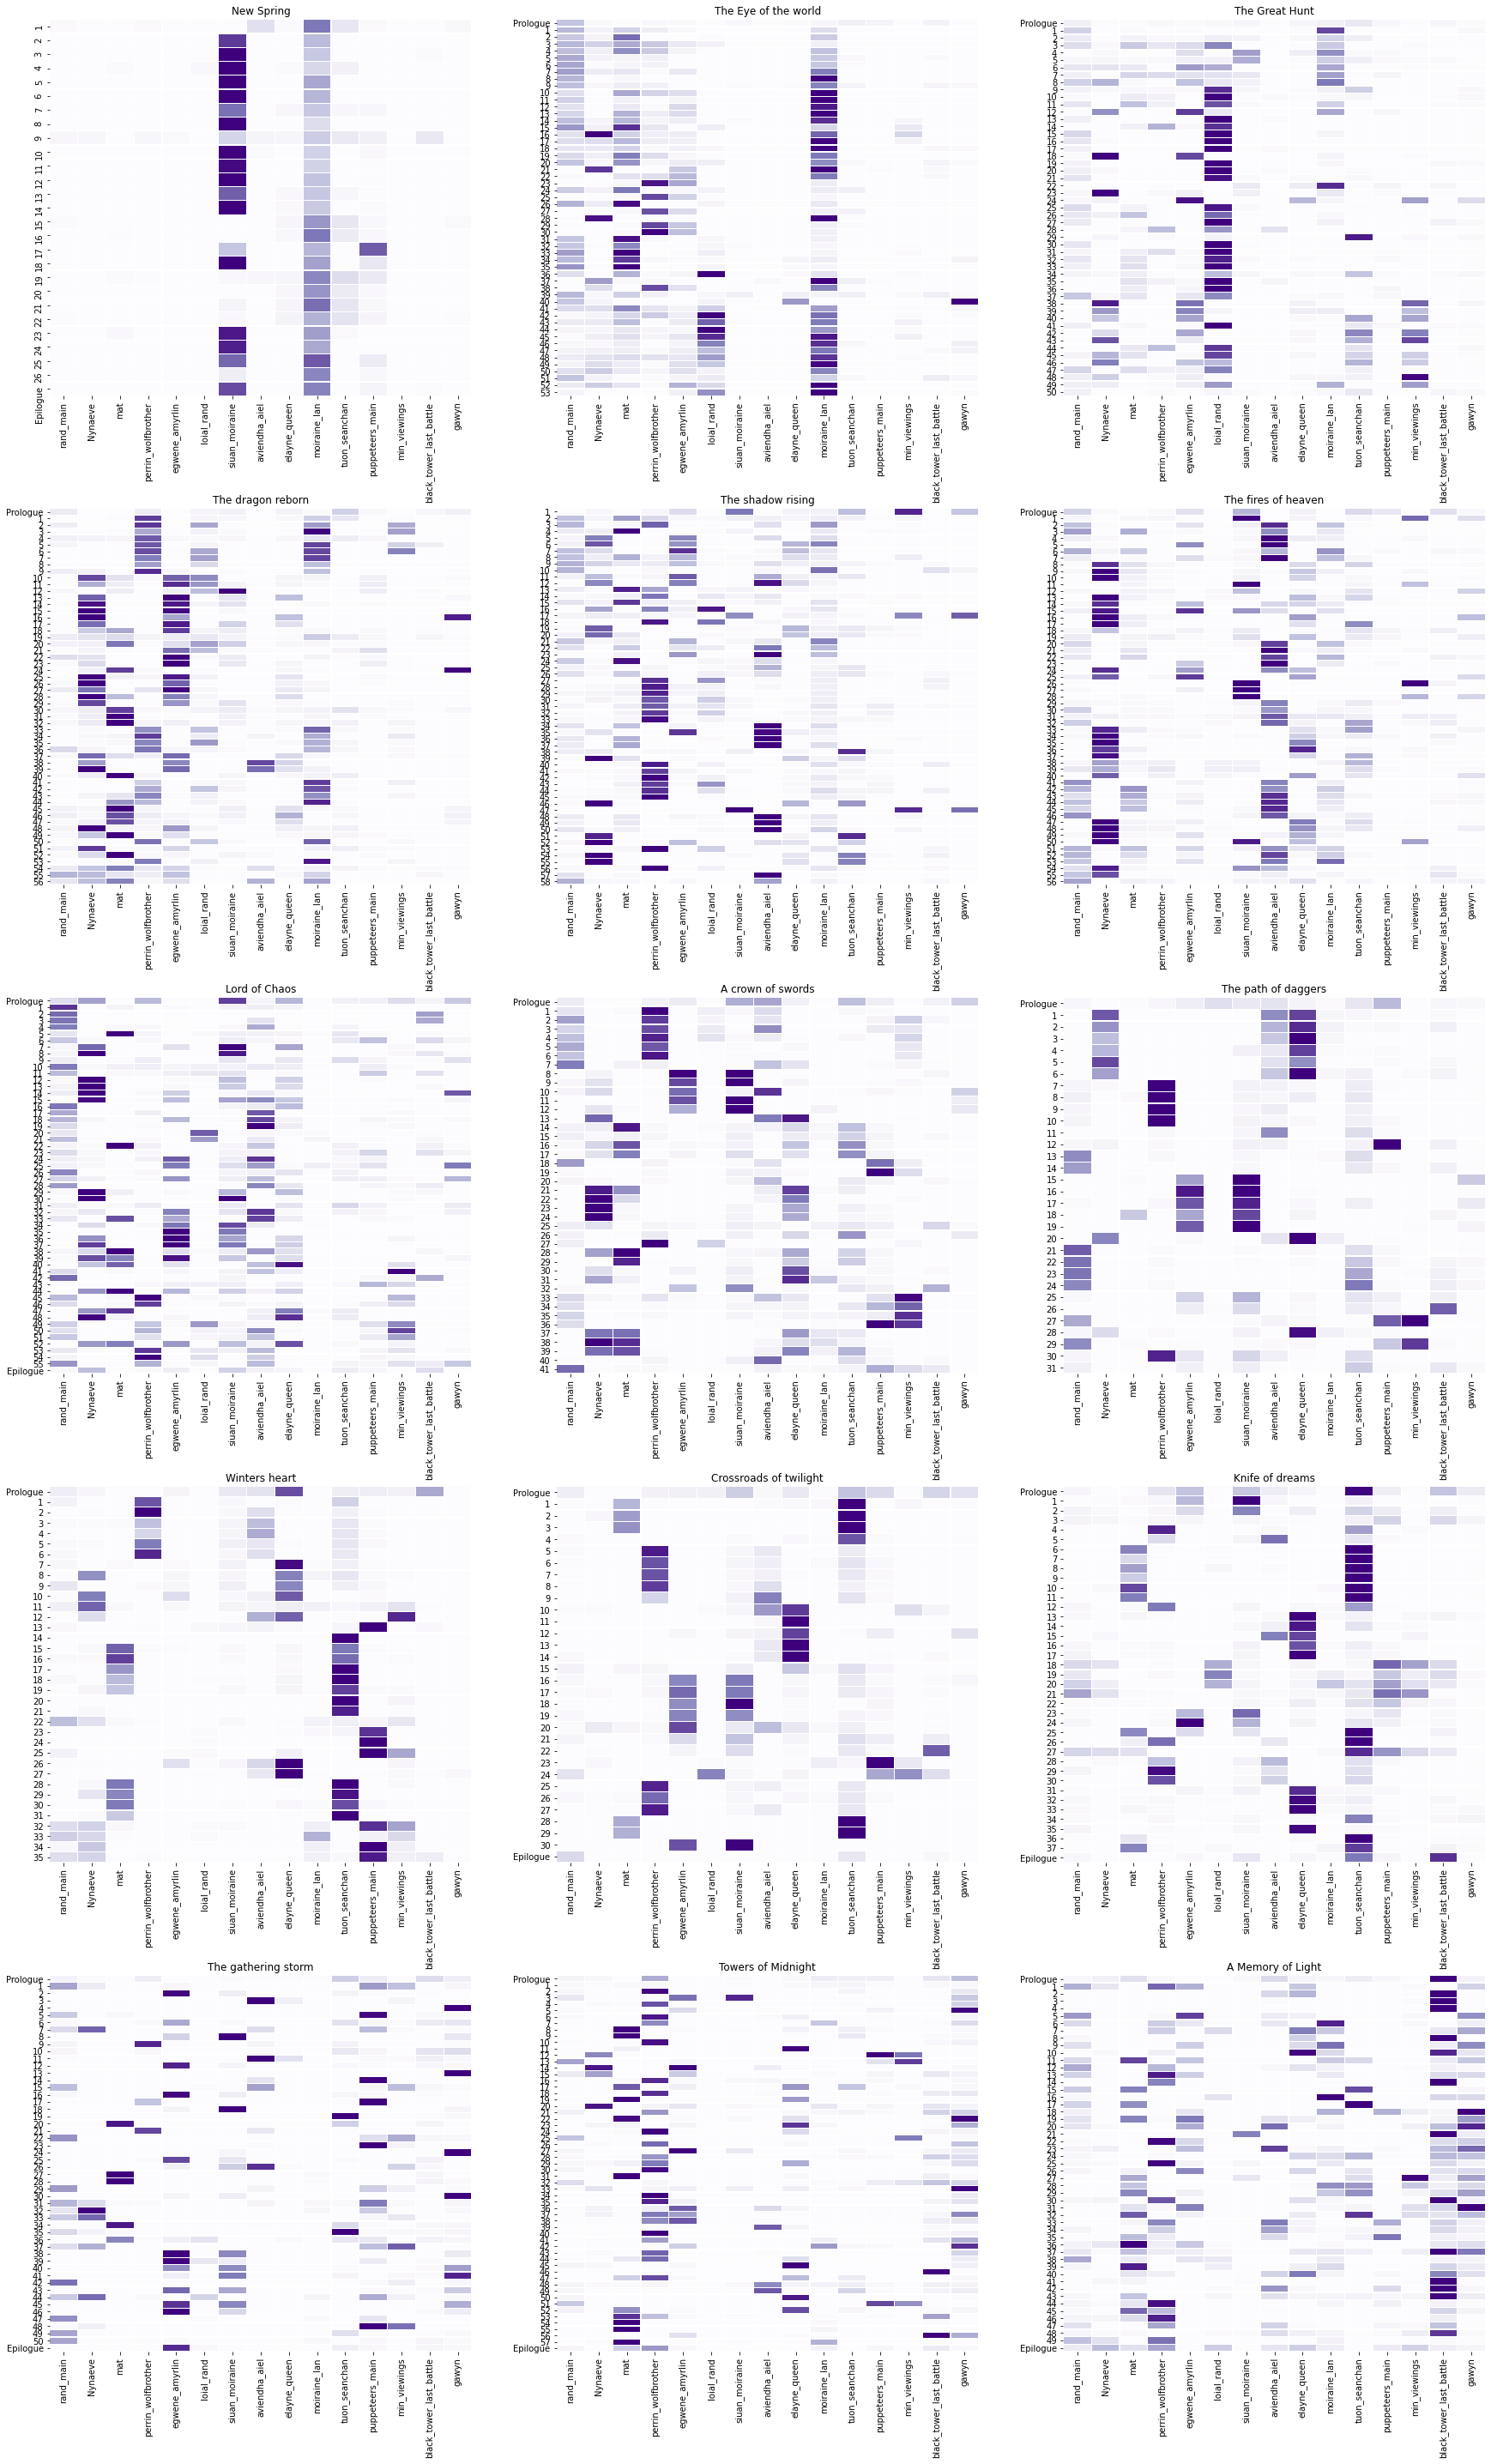

In [16]:
books = df.book_title.unique()
fig, axs = plt.subplots(5,3, figsize=(30,50))
fig.subplots_adjust(hspace = .3, wspace=.2)
axs = axs.ravel()

for idx, book in enumerate(books):
    df_new = df[df.book_title == book]
    sns.heatmap(df_new[topics], cmap='Purples', robust=True, cbar=False, 
            yticklabels=df_new.chapter_nr, linewidths=0.2, ax=axs[idx])
    axs[idx].title.set_text(book)
    
plt.show;

## Summarized by Book

In [17]:
books = pd.read_pickle('../data_files/book_corpus.pickle')
books_metadata = pd.read_excel('../data_files/chapters_and_pov.xlsx', sheet_name='books', engine='openpyxl', 
                               usecols='A:E')

In [18]:
books_tf1 = tf1.transform(books)
books_dtm = pd.DataFrame(books_tf1.toarray(), columns=tf1.get_feature_names())

In [19]:
doc_topic_books = nmf_model.transform(books_dtm)
doc_topic_books_df = pd.DataFrame(doc_topic_books, columns= topics)

In [20]:
# Combine into single Dataframe
books_combined = books_metadata
books_combined['clean_text'] = books.values
books_combined['word_count'] = books_combined['clean_text'].str.count(' ') + 1
books_combined['unique_words'] = books_combined.loc[:,'clean_text'].apply(find_unique)
books_combined = books_combined.merge(doc_topic_books_df, left_index=True, right_index=True)

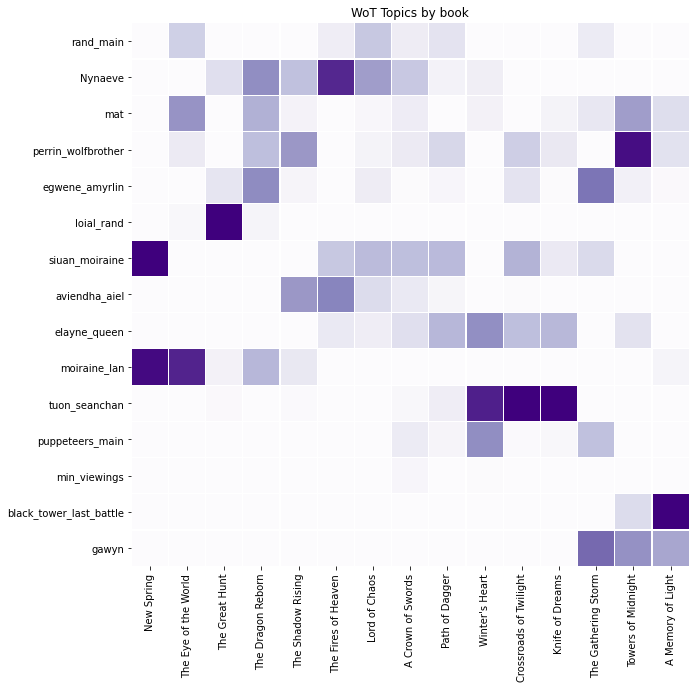

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('WoT Topics by book')
sns.heatmap(books_combined[topics].T, cmap='Purples', robust=True, cbar=False, vmin = 0.05,
           xticklabels=books_combined.Book, linewidths=0.2)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
fig.savefig('../viz/book_agg.png', dpi=600, bbox_inches='tight', transparent=False)
plt.show;

In [22]:
# Summarizing the chapters Dataframe by book and resetting index to merge with book Dataframe
chap_summary_by_book = (df[['book_title', 'book_nr', 'chapter_title', 'sent_neg', 'sent_pos', 'sent_neu', 'unique_words']]
       .groupby('book_title', as_index=False)
 .agg({'chapter_title': 'count', 'book_nr': 'max',
      'sent_neg':'mean', 'sent_pos':'mean', 'sent_neu':'mean', 'unique_words': 'mean'
      })
      .sort_values('book_nr')
      .reset_index(drop=True))
chap_summary_by_book.rename(columns={'chapter_title':'chapter_count', 'unique_words':'avg_unique_words'}, inplace=True)

In [23]:
books_combined = books_combined.merge(chap_summary_by_book, left_index=True, right_index=True)

In [24]:
books_combined[['book_title', 'Rating', 'nr_ratings', 'nr_pov', 'unique_pov', 'word_count', 'unique_words', 'avg_unique_words'
               , 'chapter_count', 'book_nr', 'sent_neg', 'sent_pos', 'sent_neu']].to_csv('../data_files/books_viz.csv')

## Lowest rated book

The lowest rated book in the series is book 10, Crossroads of Twilight. Let's see if training a separate model for a single book gives us more granular topics.

In [25]:
book_10_corpus = combined[combined.book_title == 'Crossroads of twilight']['clean_text']

In [26]:
tf2 = TfidfVectorizer(stop_words=stop_words_stemmed, ngram_range=(1, 1), tokenizer=stem_tokenizer, min_df=2, max_df=0.9)
book_10_tf2 = tf2.fit_transform(book_10_corpus)
book_10_dtm = pd.DataFrame(book_10_tf2.toarray(), columns=tf2.get_feature_names())

In [27]:
nmf2 = NMF(10)
nmf_model2 = nmf2.fit(book_10_dtm)
doc_topic2 = nmf_model2.transform(book_10_dtm)

# Naming topics from NMF and creating Dataframe:
topics2 = ['egwene_politics', 'perrin_lord', 'mat_tuon', 'elayne_politics', 'cadsuane_pov', 'alviarin_deposed'
          ,'seanchan', 'epilogue', 'faile_captive', 'aes_sedai_politics']

display_topics(nmf_model2, tf2.get_feature_names(), 15, topic_names=topics2)


Topic: ' egwene_politics '
egwen, siuan, sitter, sister, hall, amyrlin, sheriam, tower, novic, romanda, delana, dream, ajah, lelain, anaiya

Topic: ' perrin_lord '
perrin, berelain, masema, annoura, aram, shaido, balwer, smell, gallenn, masuri, habor, arganda, darkhound, elya, mayen

Topic: ' mat_tuon '
mat, tuon, luca, egeanin, wagon, selucia, dice, seanchan, domon, noal, juilin, hors, ebou, jolin, suldam

Topic: ' elayne_politics '
elayn, aviendha, birgitt, dyelin, zaida, essand, merilil, windfind, arymilla, caemlyn, hous, sister, sumeko, andor, carean

Topic: ' cadsuane_pov '
cadsuan, min, loial, jahar, elza, logain, ogier, meris, verin, rand, alivia, samitsu, boy, lan, warder

Topic: ' alviarin_deposed '
alviarin, elaida, tower, ajah, sister, yukiri, chosen, rebel, lord, suana, talen, sitter, librari, great, room

Topic: ' seanchan '
seeker, elenia, arymilla, naean, guard, nasin, ladi, high, daman, throne, wine, doll, dagger, empir, palac

Topic: ' epilogue '
lightn, basher, thund

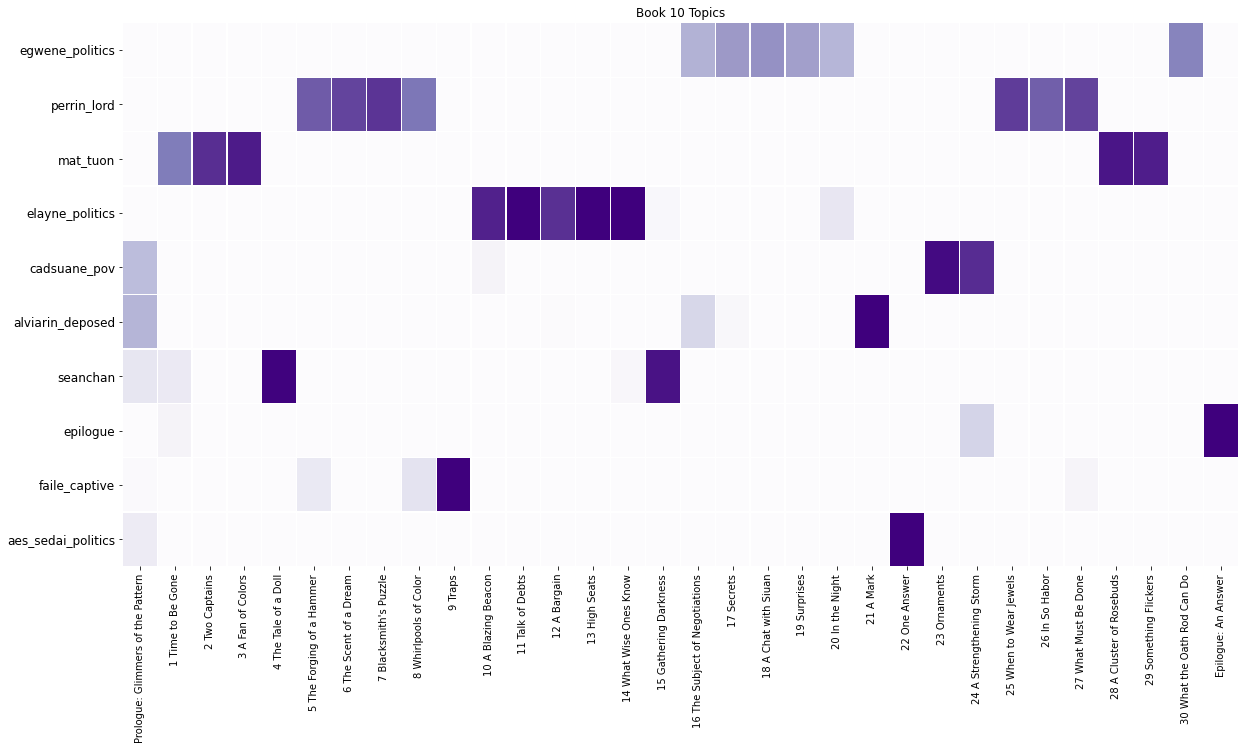

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Book 10 Topics')
sns.heatmap(doc_topic2.T, cmap='Purples', robust=True, cbar=False, vmin = 0.05, yticklabels=topics2, 
            xticklabels=combined[combined.book_title == 'Crossroads of twilight']['chapter_title'],
            linewidths=0.2)
plt.yticks(fontsize=12)
plt.xticks(fontsize=10)
fig.savefig('../viz/CoT.png', dpi=600, bbox_inches='tight', transparent=False)
plt.show;

## Reread

An extensive series of chapter summaries and commentary was created on the website of the publisher of the original book series. It can be found [here](https://www.tor.com/series/wot-reread/).  
I scraped the summaries to compare the main topics found through my model with the original (i.e. how good was the summary?)

In [29]:
reread = pd.read_pickle('../data_files/reread_corpus.pickle')

In [30]:
reread_tf1 = tf1.transform(reread)
reread_dtm = pd.DataFrame(reread_tf1.toarray(), columns=tf1.get_feature_names())
reread_doc_topic = nmf_model.transform(reread_dtm)
reread_top_df = pd.DataFrame(reread_doc_topic, columns= topics)

In [31]:
# Report accuracy
y_books = combined.main_topic
y_reread = get_main_topics(reread_top_df, topics)
print(accuracy_score(y_books, y_reread))

0.8622159090909091


In [32]:
compare = pd.concat([y_books, pd.DataFrame(y_reread, columns = ['reread'])], axis=1)

In [33]:
compare[compare.main_topic != compare.reread]

,main_topic,reread
26,siuan_moiraine,moiraine_lan
28,rand_main,mat
30,mat,Nynaeve
41,moiraine_lan,rand_main
46,moiraine_lan,mat
...,...,...
582,siuan_moiraine,gawyn
595,tuon_seanchan,rand_main
681,moiraine_lan,tuon_seanchan
682,mat,tuon_seanchan


Comparing the main topics, I realized that the lady writing the blogs has a deep knowledge of the books and is able to pick out the most critical topics with the entire storyline in mind. The model does a good job of matching her with 86% accuracy! Some of these differences are toss-ups as well, so the accuracy is even a little conservative.

However, the author of the summaries does pick out some pivotal moments that the model misses. Those are moments that are quantitatively small (and so the model assigns a different topic), but turn out to be critical to another topic. There is still something to be said for actually reading the book, rather than having the computer do it for you!